In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from math import pi
import tensorflow as tf

/user2/mtc16/mtc1614/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = input_data.read_data_sets('./data/', one_hot = False)
def one_hot_single(y):
    vector = np.zeros((y.shape[0], 9))
    
    for i in range(y.shape[0]):
        if y[i] == 6 or y[i] == 9:
            vector[i][6] = 1.
        else:
            vector[i][y[i]] = 1.
    
    return vector

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
batch_size = 1000

In [4]:
x = tf.placeholder('float', [None, 28, 28, 1])
y = tf.placeholder('float', [None, 9])

In [6]:
sigma = 1.0
weights_conv1_flat = tf.Variable(tf.random_normal([800]))
weights_conv1 = tf.reshape(weights_conv1_flat, [5, 5, 1, 32]) # First Filters
#biases_conv1 = tf.Variable(tf.random_normal([32])) 

weights_conv2 = tf.Variable(tf.random_normal([5, 5, 32, 64], stddev = sigma))
#biases_conv2 = tf.Variable(tf.random_normal([64]))

weights_fc1 = tf.Variable(tf.random_normal([7 * 7 * 64, 1024], stddev = sigma))
biases_fc1 = tf.Variable(tf.random_normal([1024], stddev = sigma))

#weights_fc2 = tf.Variable(tf.random_normal([1024, 700], stddev = sigma))
#biases_fc2 = tf.Variable(tf.random_normal([700], stddev = sigma))

weights_nca1 = tf.Variable(tf.random_normal([1024, 700], stddev = sigma))
biases_nca1 = tf.Variable(tf.random_normal([700], stddev = sigma))

weights_nca2 = tf.Variable(tf.random_normal([700, 300], stddev = sigma))
biases_nca2 = tf.Variable(tf.random_normal([300], stddev = sigma))

weights_nca3 = tf.Variable(tf.random_normal([300, 70], stddev = sigma))
biases_nca3 = tf.Variable(tf.random_normal([70], stddev = sigma))
# For MNIST, considering 6 and 9 as same softmax output
weights_softmax = tf.Variable(tf.random_normal([70, 9], stddev = sigma)) 
biases_softmax = tf.Variable(tf.random_normal([9], stddev = sigma))

In [14]:
def forward_pass(X, Y):
    
    with tf.name_scope("Convolution_Layer_1"):
        conv1 = tf.nn.conv2d(X, weights_conv1, strides = [1, 1, 1, 1], padding = 'SAME')
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    with tf.name_scope("Convolution_Layer_2"):
        conv2 = tf.nn.conv2d(conv1, weights_conv2, strides = [1, 1, 1, 1], padding = 'SAME')
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    with tf.name_scope("Fully_Connected_Layer"):
        fc1 = tf.reshape(conv2, [-1, 7 * 7 * 64])
        fc1 = tf.matmul(fc1, weights_fc1) + biases_fc1
        fc1 = tf.nn.relu(fc1)
        #fc1_ = tf.nn.dropout(fc1, 0.9)

    with tf.name_scope("NCA_Subspace_Layer_1"):
        nca1 = tf.matmul(fc1, weights_nca1) + biases_nca1
        nca1 = tf.nn.relu(nca1)
    
    with tf.name_scope("NCA_Subspace_Layer_2"):
        nca2 = tf.matmul(nca1, weights_nca2) + biases_nca2
        nca2 = tf.nn.relu(nca2)
    with tf.name_scope("NCA_Subspace_Layer_3"):
        nca3 = tf.matmul(nca2, weights_nca3) + biases_nca3
        nca3 = tf.nn.relu(nca3)        
    with tf.name_scope("Output_Softmax_Layer"):
        output = tf.matmul(nca3, weights_softmax) + biases_softmax
    
    costPred = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = output))
    
    return [tf.nn.l2_normalize(nca3), output, costPred]

In [15]:
def rotation(X):
    
    angles = pi / 4 * np.random.randint(0, 8, batch_size)
    Z = tf.contrib.image.rotate(X, angles, interpolation = 'BILINEAR')
    
    return Z

def random_rotation(X):
    angles = 4 * pi * np.random.random(10000) - pi
    Z = tf.contrib.image.rotate(X, angles, interpolation = 'BILINEAR')
    
    return Z
#

#
data_test_images = data.test.images
data_test_images = data_test_images.reshape((data.test.num_examples, 28, 28, 1))
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    rotated_test_images = sess.run(random_rotation(x), feed_dict = {x : data_test_images})
    sess.close()    
#rotated_test_images_ = data_test_images[0 : 1000]
rotated_test_images_ = rotated_test_images[0 : 1000]
rotated_test_labels = one_hot_single(data.test.labels)
rotated_test_labels_ = rotated_test_labels[0 : 1000]

In [16]:
nca3_norm, output, costPred = forward_pass(x, y)
#opt = tf.train.AdamOptimizer()
train_opt = tf.train.AdamOptimizer().minimize(costPred)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#saver = tf.train.Saver()
num_epochs = 4
#for i in range(10):
    #with tf.Session() as sess:
            
#            sess.run(tf.initialize_all_variables())
for epoch in range(num_epochs):
    epoch_loss = 0
    counter_batch_done = 0
    for _ in range(data.train.num_examples // batch_size):
        epoch_x, epoch_y = data.train.next_batch(batch_size)
        epoch_x = sess.run(rotation(x), feed_dict = {x : epoch_x.reshape((batch_size, 28, 28, 1))})
        epoch_y = one_hot_single(epoch_y)
                #grads_and_vars = opt.compute_gradients(costPred)
                #train_opt = opt.apply_gradients(grads_and_vars)
        _, c = sess.run([train_opt, costPred], feed_dict = {x : epoch_x.reshape((batch_size, \
                                28, 28, 1)), y : epoch_y})
        print(c)
                    #z_tensor = tf.gradients(costPred, weights_conv1)       
                    #z_val = sess.run(z_tensor, feed_dict = {x : epoch_x, y : epoch_y})
                    #print(z_val)
        epoch_loss += c
        print(counter_batch_done, ' batch_done')
        counter_batch_done = counter_batch_done + 1
                #print('Epoch ', epoch, 'completed out of ', num_epochs, 'loss : ', epoch_loss)
        correct = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        z1 = accuracy.eval({x : rotated_test_images_, y : rotated_test_labels_})
        print(z1)
    print(epoch, ' Epoch Completed')

/user2/mtc16/mtc1614/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


170953150.0
0  batch_done
0.126
122977930.0
1  batch_done
0.148
102607350.0
2  batch_done
0.168
81462264.0
3  batch_done
0.168
59366932.0
4  batch_done
0.163
46631624.0
5  batch_done
0.142
37462436.0
6  batch_done
0.123
30365956.0
7  batch_done
0.127
27063086.0
8  batch_done
0.166
25269366.0
9  batch_done
0.203
25551060.0
10  batch_done
0.212
25459404.0
11  batch_done
0.221
26121266.0
12  batch_done
0.228
24295444.0
13  batch_done
0.224
19933262.0
14  batch_done
0.209
17788194.0
15  batch_done
0.191
16590041.0
16  batch_done
0.182
16417588.0
17  batch_done
0.193
15609364.0
18  batch_done
0.196
15936116.0
19  batch_done
0.21
15168266.0
20  batch_done
0.219
14367439.0
21  batch_done
0.226
12275927.0
22  batch_done
0.228
12272236.0
23  batch_done
0.239
11573421.0
24  batch_done
0.269
11744203.0
25  batch_done
0.293
10938165.0
26  batch_done
0.313
11239519.0
27  batch_done
0.317
10674888.0
28  batch_done
0.331
10728150.0
29  batch_done
0.339
9803721.0
30  batch_done
0.357
9088834.0
31  bat

In [17]:
correct = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
z1 = accuracy.eval({x : rotated_test_images_, y : rotated_test_labels_})
print(z1)

0.693


In [20]:
from sklearn.manifold import TSNE

nca3_array = sess.run(nca3_norm, feed_dict = {x : rotated_test_images_, y : rotated_test_labels_})

In [22]:
tsne = TSNE(n_components=2, random_state=0)

In [24]:
X_tsne = tsne.fit_transform(nca3_array)

In [39]:
x_min, x_max = np.min(X_tsne, 0), np.max(X_tsne, 0)
X_tsne = (X_tsne - x_min) / (x_max - x_min)

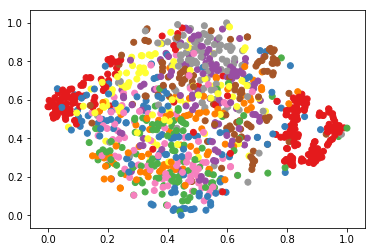

In [56]:
import matplotlib.pyplot as plt
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = plt.cm.Set1(data.test.labels / 10.))

In [55]:
data.test.labels.shape

(10000,)